In [1]:
import sys
import matplotlib.pyplot as plt
import os
import pickle

sys.path.append(r'C:\Users\Max\Documents\Python\__packages__')

import freewhisk as fw

# Read in the data

Make sure you set the right file directory for this demo to work. This is some data I took from a mouse training session in my own experiments.

In [2]:
demo_file_dir = r'C:\Users\Max\Documents\Python\__packages__\freewhisk\Demo_Files\Example1'

with open(os.path.join(demo_file_dir, 'nose_positions.p'), 'rb') as f:
    nose_positions = pickle.load(f)

with open(os.path.join(demo_file_dir, 'head_directions.p'), 'rb') as f:
    head_directions = pickle.load(f)

## Read in Video

I also included a (very basic) function to read in a video file and convert it to a numpy array, to make sure it works with my code.

In [3]:
vid_arr = fw.video_to_array(os.path.join(demo_file_dir, 'demo_video.avi'))

# Extract Raw Whisker Data

To extract the raw whisker data, we need to use the `extract_raw_whisker_data` function. This function takes in 3 variables:
- **vid_arr**: the 3D video array that we read in using the video_to_array function (see above)
- **nose_positions**: nose coordinates for each frame. This needs to be a pandas dataframe with the columns *'nose_x'* and *'nose_y'* for the x and y coordinates of the nose
- **head_directions**: head direction for each frame in degrees. This needs to be a list of the same length as the number of frames in the video 

C:\Users\Max\Documents\Python\__packages__\freewhisk\whisk_extract.py:330: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cont = np.vstack(contours[i] for i in pos)


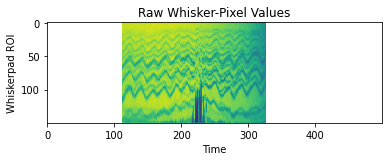

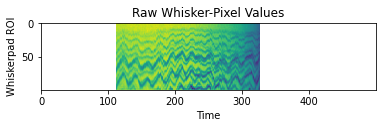

In [4]:
whisk_arr = fw.extract_raw_whisk(vid_arr, nose_positions, head_directions, crop_size = 100,sample_res = 150, side='R', roi_offset = 7, image_edge_offset = 8, plot=True)
whisk_arr4 = fw.extract_raw_whisk(vid_arr, nose_positions, head_directions, crop_size = 60, sample_res = 100, side='R', roi_offset = 7, image_edge_offset = 8, plot=True)


## Crop Size and Sample Resolution

Generally, if you plot it, the output should look like this; the dark wiggly traces are whiskers moving back and forth, showing the typical rythmic movements of the whiskers, which is called whisking. The dark spot between time 200-250 is actually the mouse's paw which unfortunately got near the whiskers and produced an artefact. This actually happens quite often in my data and it is hard to avoid since we're in a freely moving context. In head-fixed experiments, people are impressively able to track the full extent of individual whiskers during behaviour but it is basically impossible to do this in freely moving animals (or at least I haven't been able to) without employing some highly sophisticated 3D tracking system with multiple cameras, fluorescent whiskers and whatnot. However, the aim here is to have a 'simple' approach to track the global movement of the whiskerpad, so we need to be clever with how we deal with noise and artefacts.

Two parrameters that you should play around with are the **crop_size** and the **sample_res**.

The crop size lets you set to what size the video will be cropped when executing the function. This is useful if you want to reduce the size of the video to make it easier to process. Also by cropping the video more, you'll be less likely to be annoyed by artefacts (in particular from the paw). In our example, we have a fibre and the implant going to the left so our view onto the parts of the posterior whiskers will often be obstructed, so we can use a smaller crop_size to be less affected by the fibre. Such artefacts will also slow down the execution of the function. On the downside, reducing the crop size will also reduce the amount of data you have to work with later when extracting the whisking envelope and you may be ignoring the changes at more posterior whisker rows. 

The sample_res parameter lets you set the sampling resolution of the Whiskerpad ROI. This is again useful if you want to either reduce or increase the amount of data you have to work with. However, if you reduce the sampling rate too much, you'll lose a lot of information and the whisker traces will look very jagged. On the other hand, if you increase the sampling rate too much, you'll be sampling too many points, adding a lot of noise and the function will take a long time to run. It shouldn't be too hard to find a good balance between these two parameters. 

C:\Users\Max\Documents\Python\__packages__\freewhisk\whisk_extract.py:330: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cont = np.vstack(contours[i] for i in pos)


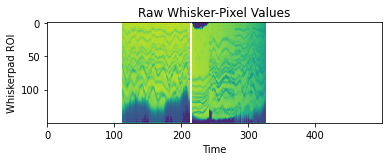

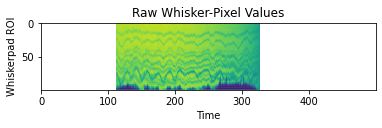

In [5]:
whisk_arr2 = fw.extract_raw_whisk(vid_arr, nose_positions, head_directions, crop_size = 100, sample_res = 150, side='L', roi_offset = 7, image_edge_offset = 8, plot=True)
whisk_arr3 = fw.extract_raw_whisk(vid_arr, nose_positions, head_directions, crop_size = 60, sample_res = 100, side='L', roi_offset = 7, image_edge_offset = 8, plot=True)

## Other Parameters

For the side parameter you can choose between 'L' or 'R' to indicate which side of the whiskerpad you want to look at.

There are a few other parameters that you can play around with. Roi_offset sets the offset of the ROI from the whiskerpad. I like to keep it low because otherwise we'll have problems when mice come near obstacles or the edge of the alley. Also the whiskers will be less clearat higher distances. An offset that's too low may become problematic if the ROI is not anymore in front of the whiskerpad, but goes through the snout and you'll see artefacts in your raw extracted data.

The image_edge_offset parameter helps mask out the edges of the video due to the rotation of the image to align it with the mouse's head direction. This is a bit of a hacky solution but it works well enough. I'd recommend keeping it at 8 pixels.

# Extract Whisking Envelope

The 2nd main step is to extract the whisking envelope. This is done using the `extract_whisking_envelope` function. This function takes in 1 variable: The raw whisker-pixel values. This is the output of the `extract_raw_whisk` function. As you'll be able to see, it is quite robust to noise and artefacts. You'll also see that no matter what, each bout of whisking envelope always starts at 60. This is because for now I haven't been able to find a way to extract the absolute setpoint. I'm still working on it, but for now we should only think of this whisking envelope as a relative measure of whisking activity.

I also like using the `savgol_smooth` function to smooth out the whisking envelope a bit.

The parameters can be a bit tricky to understand. I haven't had to change them at all for my own data, but you may need to play around with them to get the best results for your data, in particular the prominence and pixel_scale.

The **prominence** parameter is used to set the prominence threshold for the peaks. If you set it too high, you'll miss peaks and if you set it too low, you'll get a lot of noise. I like to keep it very low because I want to capture as many peaks as possible.

The **pixel_scale** parameter is used to weight the importance of pixel intensity when tracking peaks over time. I like to keep it at a similar value to the sample_resolution used when using the `extract_raw_whisk` function. This means that y-position and pixel intensity are weighted equally when tracking peaks.

The **bin_size** parameter is used to set the size of the sliding window that will be used to track the global movement of peaks over time. Because we're working with noisy data I like to keep it low (we're less likely to reject tracked peak traces over short distances).

The **cutoff** parameter is used to set the y-position cutoff for detecting peaks.

The **mean_setpoint** is used to set the starting point for the whisking envelope. This is a very preliminary solution and I'm still working on it.

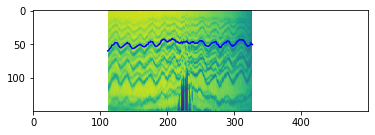

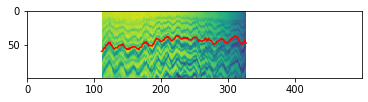

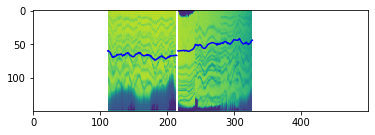

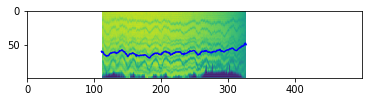

In [6]:
mean_angle = fw.extract_whisking_envelope(whisk_arr, prominence=0.03, cutoff=4, pixel_scale=100, bin_size=3, mean_setpoint = 60)

plt.imshow(whisk_arr)
plt.plot(mean_angle, 'b')
plt.show()

mean_angle4 = fw.extract_whisking_envelope(whisk_arr4, prominence=0.03, cutoff=4, pixel_scale=100, bin_size=3, mean_setpoint = 60)

plt.imshow(whisk_arr4)
plt.plot(mean_angle4, 'r')
plt.show()

mean_angle2 = fw.extract_whisking_envelope(whisk_arr2, prominence=0.03, cutoff=4, pixel_scale=100, bin_size=3, mean_setpoint = 60)

plt.imshow(whisk_arr2)
plt.plot(mean_angle2, 'b')
plt.show()

mean_angle3 = fw.extract_whisking_envelope(whisk_arr3, prominence=0.03, cutoff=4, pixel_scale=100, bin_size=3, mean_setpoint = 60)

plt.imshow(whisk_arr3)
plt.plot(mean_angle3, 'b')
plt.show()




# Compute Whisking Metrics

The 3rd main step is to compute whisking metrics. For now I have been extracting the following whisking metrics from my whisking envelope: Whisking Amplitude, Whisking Speed, Whisking Frequency, Whisking Phase and whether the animal is protracting or retracting its whiskers.

## Whisking Amplitude, Speed and Protraction/Retraction

To compute the whisking amplitude, speed and protraction/retraction, I use the `compute_trial_amps_and_speeds` function. This function takes in the whisking envelope and returns 4 parameters:
- **All_Amplitudes**: Whisking position expressed as the amplitude at each particular timepoint. So if the animal is just starting to pro/retract, the amplitude will be low and by the end of the pro/retraction, the amplitude will be higher. I like to use this to plot the whisker movements by position.
- **Max_Amplitudes**: Whisking position expressed as the maximum amplitude at each particular pro/retraction. This is useful for getting a measure of overall whisking amplitude.
- **Whisk_Speeds**: Whisking speed at each particular timepoint. Calculated by dividing the whisking amplitude by the time it takes to complete it.
- **Pro- or Retraction**: Whether the animal is protracting or retracting its whiskers at each particular timepoint. This is useful for plotting whisking protraction/retraction by position, or seperate other whisking metrics by protraction/retraction.

Additionally, I recommend setting s amoothing factor for the max amplitude and whisking speed using the amp_smooth (default 31) and speed_smooth (default 51) parameters. Make sure it's an uneven number or it won't work.

In [7]:
all_whisk_amps, max_amps, whisk_speeds, pro_or_ret = fw.compute_trial_amps_and_speeds(mean_angle)

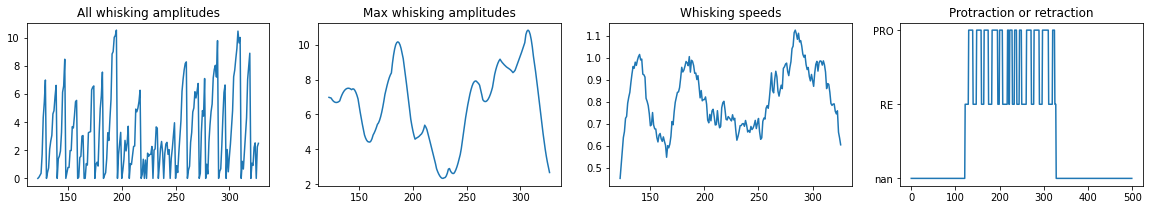

In [8]:
fig, ax = plt.subplots(1,4, figsize=(20,3))

ax[0].title.set_text('All whisking amplitudes')
ax[0].plot(all_whisk_amps)

ax[1].title.set_text('Max whisking amplitudes')
ax[1].plot(max_amps)

ax[2].title.set_text('Whisking speeds')
ax[2].plot(whisk_speeds)

ax[3].title.set_text('Protraction or retraction')
ax[3].plot(pro_or_ret)


## Whisking Phase and Frequency

To compute the whisking frequency and phase, I use the `compute_trial_phases_and_freq` function. This function takes in the whisking envelope and returns 2 parameters:

- **Whisk_Phases**: Whisking phase at each particular timepoint. Maximum Protraction is 1, Maximum Retraction is 0. Values between 0 and 1 mean the animal is protracting. Values between 1 and 2 mean the animal is retracting. 
- **Whisk_Freqs**: Whisking frequency at each particular timepoint in Hz.

Additionally, I recommend setting a smoothing factor for the frequency using the freq_smooth (default 11) parameter. Make sure it's an uneven number or it won't work.

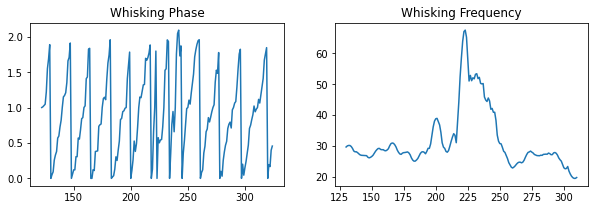

In [10]:
phases, freqs = fw.compute_trial_phases_and_freqs(mean_angle)

fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].title.set_text('Whisking Phase')
ax[0].plot(phases)

ax[1].title.set_text('Whisking Frequency')
ax[1].plot(freqs)

plt.show()

# Future Work

I'm currently working on a few things:
- Extracting the absolute setpoint of the whisking envelope
- Extracting the whisker spread from the raw whisker pixel intensity values
- Faster processing time

As of now I've only used my own data, so I'm not sure how well it will work on other data. I tried my best to make it as robust as possible, but I'm sure there are still some bugs. If you find any bugs or have any suggestions, please let me know!